In [1]:
import torch
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from src.model.models import MLP
from src.data.helpers import list_to_model, get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary


In [2]:
class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)

        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"]).astype('float32')
        self.angles = self.dataset["angle"]*np.pi/180

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].values)
        angle = torch.tensor(self.angles.iloc[idx])

        return weights, angle

In [11]:
class Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(128),
            torch.nn.Linear(128, 16),
            torch.nn.Tanh(),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 128),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(128),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 33),
        )

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [ ]:
config = {
    "model":{
        "name": "Autoencoder",
        "layers": [33, 512, 1024, 512, 256, 128, 128]
    },
    "hyperparameters":{
        "epochs": 150,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam",
    }
}

path = f"../../models/autoencoders/contrastive_loss"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

autoencoder = Autoencoder()
autoencoder.to(device)
loss_fn = torch.nn.MSELoss()
latent_loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [17]:
autoencoder.train()
for i in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        sin = torch.sin(y)
        cos = torch.cos(y)

        l = autoencoder.encoder(X)
        lg = l.clone()
        lg[:, 0] = sin
        lg[:, 1] = cos

        output = autoencoder.decoder(l)

        rl = loss_fn(output, X)
        ll = latent_loss_fn(l, lg)
        # ll = 0

        loss = rl + ll
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')
        torch.save(autoencoder.state_dict(), f"{path}/autoencoder_{i}.pth")
    
torch.save(autoencoder.state_dict(), f"{path}/autoencoder_final.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1, Loss: 1.8947088718414307
Epoch: 6, Loss: 0.9403586983680725
Epoch: 11, Loss: 0.6650832295417786
Epoch: 16, Loss: 0.509423017501831
Epoch: 21, Loss: 0.4080820381641388
Epoch: 26, Loss: 0.31345024704933167
Epoch: 31, Loss: 0.2663978338241577
Epoch: 36, Loss: 0.3051029145717621
Epoch: 41, Loss: 0.2476010024547577
Epoch: 46, Loss: 0.24615535140037537
Epoch: 51, Loss: 0.24971652030944824
Epoch: 56, Loss: 0.24467407166957855
Epoch: 61, Loss: 0.22771593928337097
Epoch: 66, Loss: 0.21639229357242584
Epoch: 71, Loss: 0.26973724365234375
Epoch: 76, Loss: 0.21136382222175598
Epoch: 81, Loss: 0.22062020003795624
Epoch: 86, Loss: 0.1753048300743103
Epoch: 91, Loss: 0.17153504490852356
Epoch: 96, Loss: 0.14857345819473267
Epoch: 101, Loss: 0.15658113360404968
Epoch: 106, Loss: 0.16224335134029388
Epoch: 111, Loss: 0.14403973519802094
Epoch: 116, Loss: 0.13536478579044342
Epoch: 121, Loss: 0.125877246260643
Epoch: 126, Loss: 0.11635775864124298
Epoch: 131, Loss: 0.1481504589319229
Epoch: 13

C:\Projects\Python\master-thesis\src\data\helpers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data = torch.tensor(parameters_from_list, dtype=torch.float32).reshape(param.shape)


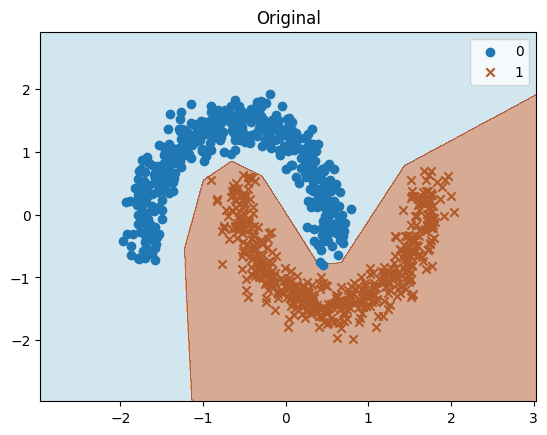

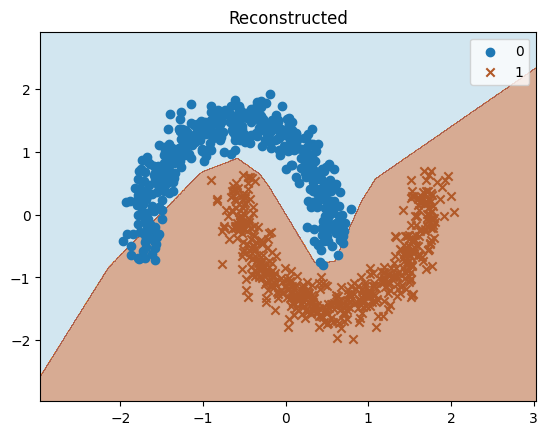

In [7]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()
model1 = MLP(2, [8], 1)
model2 = MLP(2, [8], 1)

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()
X,y = get_moons_dataset()

index = 1000
X_rotated = rotate(X, angles[index])
w = torch.tensor(weights[index])

o = autoencoder(w.unsqueeze(0)).squeeze().detach().numpy()
list_to_model(model1, w)
list_to_model(model2, o)

plot_decision_boundary(model1, X_rotated, y, title="Original")
plot_decision_boundary(model2, X_rotated, y, title="Reconstructed")

(80000, 16)
(80000, 3)


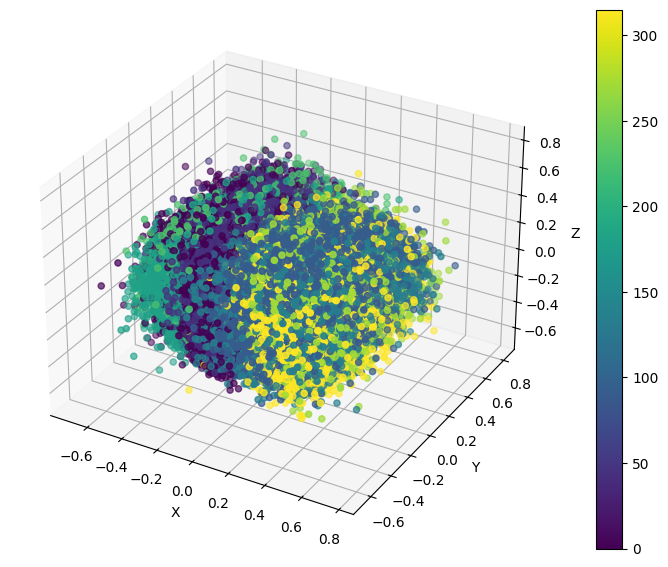

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder()
checkpoint = 95
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

latent = autoencoder.encoder(torch.tensor(weights).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(90, 0, 0)

plt.show()

(80000, 16)
(80000, 3)


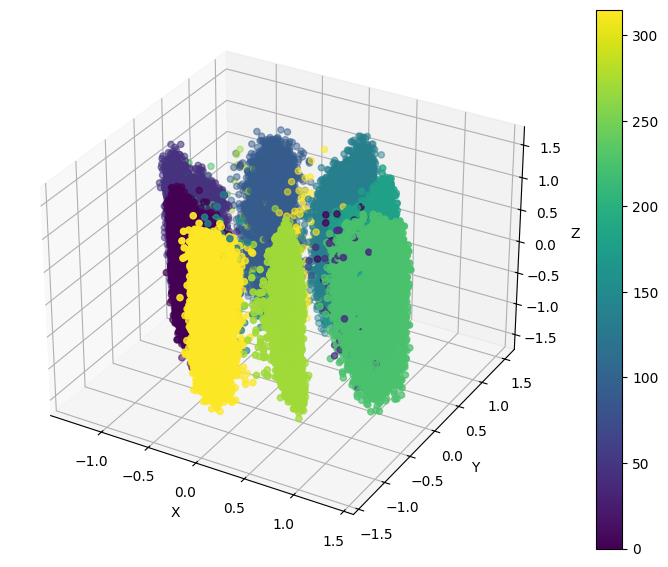

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder()
checkpoint = 95
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

latent = autoencoder.encoder(torch.tensor(weights).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(90, 0, 0)

plt.show()

C:\Projects\Python\master-thesis\src\data\helpers.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data = torch.tensor(parameters_from_list, dtype=torch.float32).reshape(param.shape)


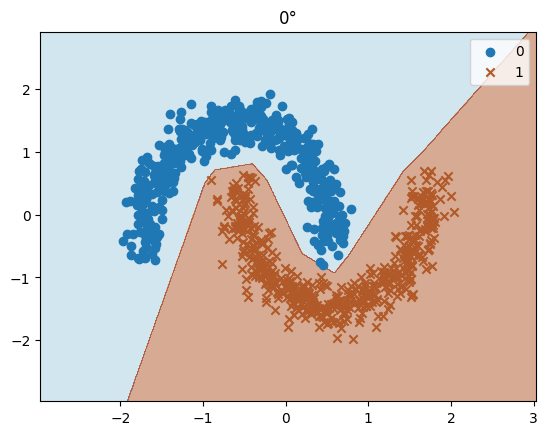

In [8]:
raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()
X,y = get_moons_dataset()

autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()
model = MLP(2, [8], 1)

index = 0
w = weights[index]
w = torch.tensor(w).float()
a = angles[index]

# l = autoencoder.encoder(w)
# s = torch.sin(torch.tensor(45*np.pi/180))
# c = torch.cos(torch.tensor(45*np.pi/180))
# l[0] = s
# l[1] = c

# o = autoencoder.decoder(l).detach().numpy()

X_rotated = rotate(X, a)
list_to_model(model, w)

plot_decision_boundary(model, X_rotated, y, title=f"{a}°")

## With extra angles

(100000, 16)
(100000, 3)


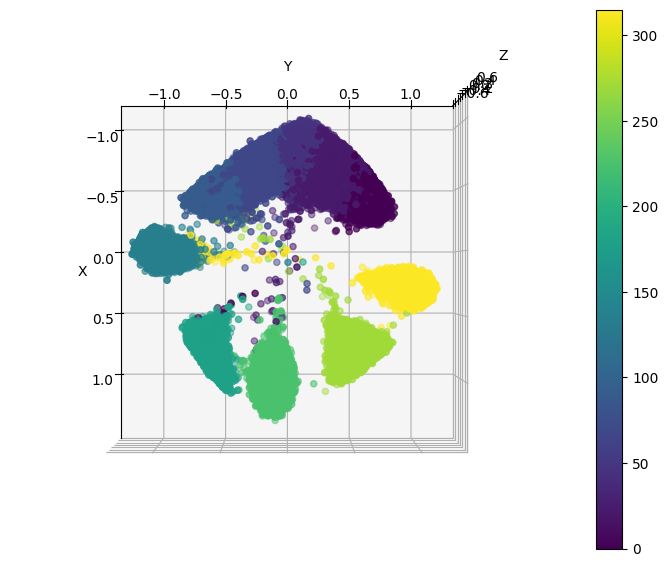

In [65]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder()
checkpoint = 95
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
extra = pd.read_csv("../data/extra_angles.csv")
raw = pd.concat([raw, extra])
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

latent = autoencoder.encoder(torch.tensor(weights).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], -X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(90, 0, 0)

plt.show()

(10000, 16)
[ 0.75116694  0.31608585  0.01681182  0.04568607 -0.00149487 -0.00350557
 -0.02090614  0.01603163  0.00189478 -0.05985357  0.00319915  0.01111363
  0.02097854  0.00126441  0.00526116  0.00553812]


<BarContainer object of 16 artists>

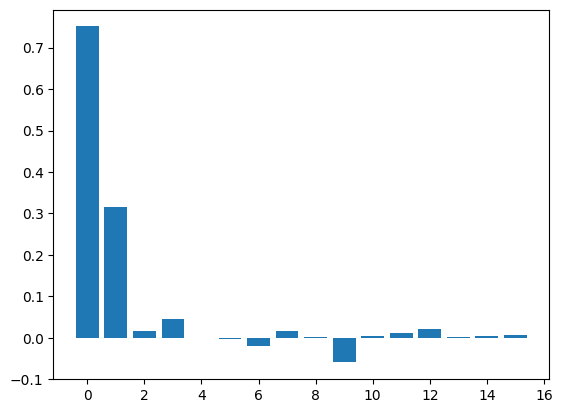

In [100]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()

raw = pd.read_csv("../data/extra_angles.csv")
raw = raw[raw["angle"] == 67]
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

latent = autoencoder.encoder(torch.tensor(weights).float()).detach().numpy()
print(latent.shape)

latent = np.sum(latent, axis=0)/latent.shape[0]

print(latent)

plt.bar(range(16), latent)

## Trained models

In [4]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

C:\Projects\Python\master-thesis\src\data\helpers.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data = torch.tensor(parameters_from_list, dtype=torch.float32).reshape(param.shape)


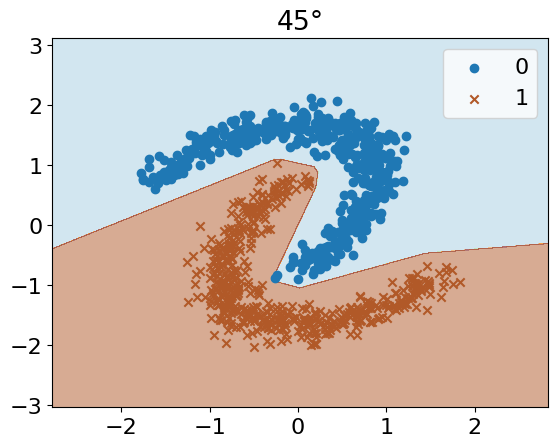

In [33]:
raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()
X, y = get_moons_dataset()

index = 63000
w = weights[index]
w = torch.tensor(w).float()
a = angles[index]
X_rotated = rotate(X, a)

model = MLP(2, [8], 1)
list_to_model(model, w)

plot_decision_boundary(model, X_rotated, y, title=f"{a}°")

## Sample

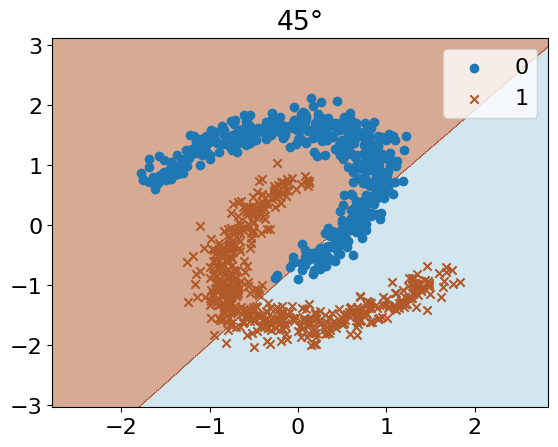

In [35]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()

model = MLP(2, [8], 1)

X,y = get_moons_dataset()

angle = 45

latent = torch.rand(1, 16)*2-1
latent[0, 0] = np.sin(angle*np.pi/180)
latent[0, 1] = np.cos(angle*np.pi/180)
X_rotated = rotate(X, angle)

output = autoencoder.decoder(latent).squeeze().detach().numpy()
list_to_model(model, output)

plot_decision_boundary(model, X_rotated, y, title="45°")

## Interpolate

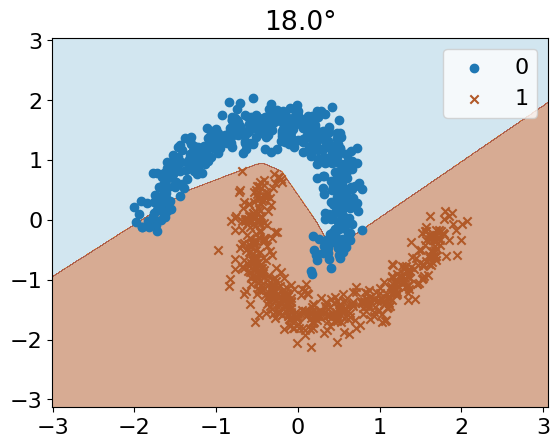

In [38]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
autoencoder.eval()
model = MLP(2, [8], 1)

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()
X,y = get_moons_dataset()

w0 = weights[angles == 0]
w45 = weights[angles == 45]

index = 0
alpha = 0.4
w = torch.tensor( (1-alpha)*w0[index] + alpha*w45[index] ).unsqueeze(0).float()
a = (1-alpha)*0 + alpha*45

X_rotated = rotate(X, a)

o = autoencoder(w).squeeze().detach().numpy()
list_to_model(model, o)

plot_decision_boundary(model, X_rotated, y, title=f"{a}°")